In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [2]:
f_size = 16
fig_size = (6,4)

In [3]:
def plot_bar_with_curve(bits, arc_easy, lambada, piqa, title="acc_bit_opt", labels=['arc_easy', 'lambada', 'piqa'],\
                       y_label='Accuracy'):
    x = np.arange(len(bits))
    width = 0.2

    fig, ax = plt.subplots(figsize=fig_size)

    bar1 = ax.bar(x - width, arc_easy, width, label=labels[0])
    bar2 = ax.bar(x, lambada, width, label=labels[1])
    bar3 = ax.bar(x + width, piqa, width, label=labels[2])

    ax.plot(x, arc_easy, '-o')
    ax.plot(x, lambada, '-o')
    ax.plot(x, piqa, '-o')

    ax.set_xticks(x)
    ax.set_xticklabels(bits, fontsize=f_size)

    ax.set_xlabel('Bitwidth',  fontsize=f_size+2)
    ax.set_ylabel(y_label,  fontsize=f_size+2)
#     ax.set_title('Accuracy vs Bit')
    
    ax.legend(fontsize=14, loc='upper right')
    plt.savefig(f'{title}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

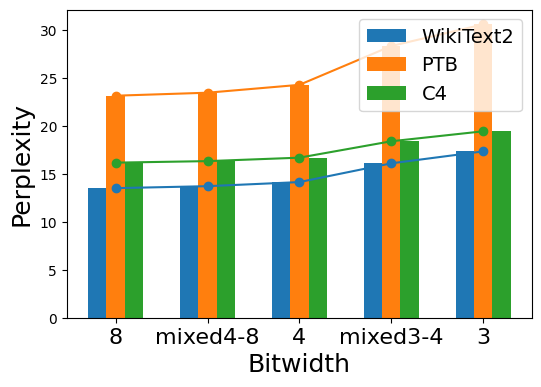

In [4]:
title = "pp_bit_bloom"
bits = [8, 'mixed4-8', 4, 'mixed3-4', 3]
labels = ['WikiText2', 'PTB', 'C4']
WikiText2 = [13.502, 13.707, 14.134, 16.088, 17.333]
PTB = [ 23.135, 23.447, 24.267, 28.313,30.566]
C4 = [16.16, 16.318, 16.678, 18.388, 19.426]
plot_bar_with_curve(bits, WikiText2, PTB, C4, title, labels,y_label='Perplexity')

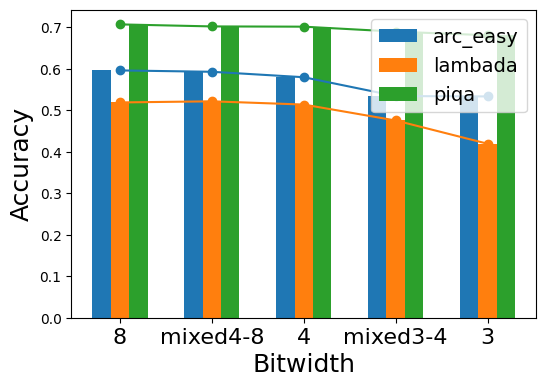

In [5]:
title = "acc_bit_bloom"
bits = [8, 'mixed4-8', 4, 'mixed3-4', 3]
labels = ['arc_easy', 'lambada', 'piqa']
arc_easy = [0.5963, 0.593, 0.5799, 0.5345, 0.5336]
lambada = [0.5191, 0.5218, 0.514, 0.4756, 0.4195]
piqa = [0.70729, 0.70239, 0.7018, 0.6898, 0.6811]
plot_bar_with_curve(bits, arc_easy, lambada, piqa, title, labels)

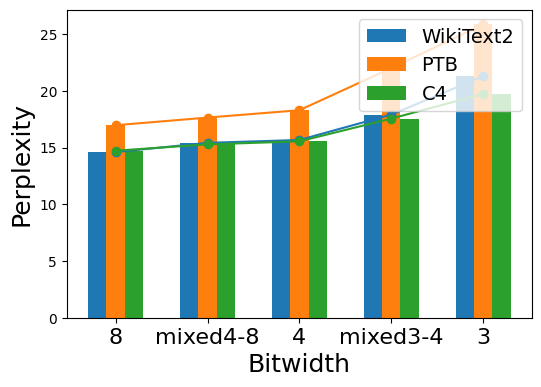

In [6]:
title = "pp_bit_opt"
bits = [8, 'mixed4-8', 4, 'mixed3-4', 3]
labels = ['WikiText2', 'PTB', 'C4']
WikiText2 = [14.611, 15.421, 15.674, 17.912, 21.295]
PTB = [ 16.975, 17.65, 18.298, 22.012,25.867]
C4 = [14.73, 15.285, 15.554, 17.559, 19.737]
plot_bar_with_curve(bits, WikiText2, PTB, C4, title, labels,y_label='Perplexity')

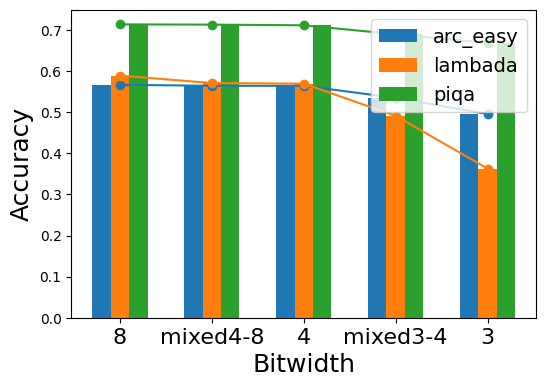

In [7]:
title = "acc_bit_opt"
bits = [8, 'mixed4-8', 4, 'mixed3-4', 3]
labels = ['arc_easy', 'lambada', 'piqa']
arc_easy = [0.5669, 0.5643, 0.5643, 0.5349, 0.4957]
lambada = [0.5891, 0.5711, 0.5695, 0.4913, 0.36289]
piqa = [0.7138, 0.7132, 0.7116, 0.6898, 0.6686]

plot_bar_with_curve(bits, arc_easy, lambada, piqa, title, labels)

In [8]:
# Motivation: Latency
# four graph
# batch size as x-axis. 2, 4, 8
# Left T4, Right V100
# Each graph with batchsize as x-axis, each precision as stacks
# Top: prefill, bottom: decode

In [10]:
# directly load the cost model
from shaq.cost_model import LatCostModel
profiled_result_folder = '/workspace/shaq/scripts/lat_profiled_result/'
device_names = ['Tesla_V100-SXM2-32GB', 'Tesla_T4']
lat_cost_model = LatCostModel(device_names)
lat_cost_model.update_profiled_result(profiled_result_folder) # load the data

In [21]:
# Data
batch_sizes = [2, 4, 8]
available_bits = [3, 4, '8:tc-li', 16]

# Reference
# T4_result = {
#     'prefill': {
#         3: [2226.458931, 4468.593407, 8890.639544],
#         4: [2844.448304, 5654.017258, 11203.58102],
#         8: [40.5836165, 81.82716966, 173.6923337],
#         16: [67.00835228, 124.6872902, 262.5949144],
#     },
#     'decode': {
#         3: [4.211550951, 8.830219507, 18.77187192],
#         4: [5.092430115, 12.01024652, 23.80271256],
#         8: [6.061634421, 6.596380472, 7.886072993],
#         16: [5.853676796, 6.477093697, 7.772779465],
#     }
# }

# V100_result = {
#     'prefill': {
#         3: [413.0125761, 829.2733431, 1663.913631],
#         4: [555.6130171, 1112.234402, 2237.720752],
#         8: [21.85966969, 41.45514965, 85.11660099],
#         16: [16.05703831, 31.77056313, 75.61903],
#     },
#     'decode': {
#         3: [2.086257935,2.682542801,4.653978348],
#         4: [2.043867111,3.209066391,5.690550804],
#         8: [7.271099091,7.519483566,8.077287674],
#         16: [2.441263199,2.69920826,3.182959557],
#     }
# }

h1, h2 = 7168, 28672 # 30b
shard = 2 # attention + ffn
s = 512 
# prefill
def fill_in_result(result, shard, s, i, h1, h2):
    for device_name in device_names:
        if device_name not in result:
            result[device_name] = {}
        for b in batch_sizes:
            for bit in available_bits:
                if bit not in result[device_name]:
                    result[device_name][bit] = []
                lat = lat_cost_model.fetch_lat(device_name, shard, b, s, i, h1, h2, bit)
                result[device_name][bit].append(lat)  
result_prefill = {}
result_decode = {}
fill_in_result(result_prefill, shard, s, 0, h1, h2)
fill_in_result(result_decode, shard, 1, s, h1, h2)

V100_result = {
    'prefill': result_prefill['Tesla_V100-SXM2-32GB'],
    'decode': result_decode['Tesla_V100-SXM2-32GB']
}

T4_result = {
    'prefill': result_prefill['Tesla_T4'],
    'decode': result_decode['Tesla_T4']
}

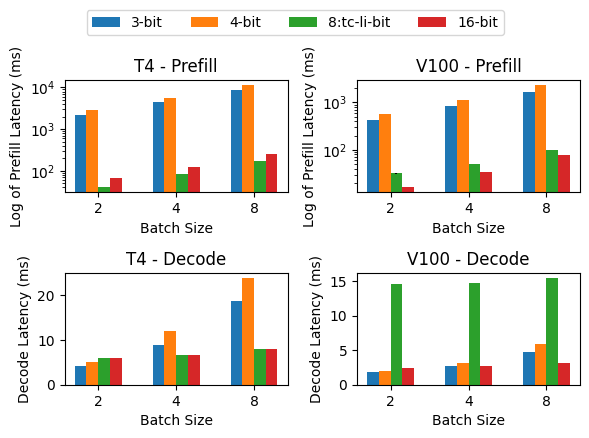

In [22]:
# Plotting
# fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True)
fig, axs = plt.subplots(2, 2, figsize=(6, 4))
for i, (result, title) in enumerate(zip([T4_result, V100_result], ['T4', 'V100'])):
    for j, (operation, ylabel) in enumerate(zip(['prefill', 'decode'], ['Log of Prefill Latency (ms)', 'Decode Latency (ms)'])):
        ax = axs[j][i]
        ax.set_title(f"{title} - {operation.capitalize()}")
        ax.set_xlabel('Batch Size')
        ax.set_ylabel(ylabel)

        x = np.arange(len(batch_sizes))  # the label locations
        width = 0.15  # the width of the bars

        for idx, bits in enumerate(available_bits):
            # Extract data for the current available bits
            y = [result[operation][bits][j] for j in range(len(batch_sizes))]
            if title in ['T4', 'V100'] and operation == 'prefill':
                # Use logarithmic scale for prefill latency in T4 and V100
                ax.bar(x + (idx - 1.5) * width, y, width, label=f'{bits}-bit', yerr=0.1)
                ax.set_yscale('log')
            else:
                ax.bar(x + (idx - 1.5) * width, y, width, label=f'{bits}-bit')
        
        ax.set_xticks(x)
        ax.set_xticklabels(batch_sizes)
#         ax.legend()

# Create a legend for the available bits at the top of the whole graph
handles, labels = axs[0][0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', ncol=len(available_bits), bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
# plt.savefig('motive_prefill_decode_perf.pdf')
fig.savefig('motive_prefill_decode_perf.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()
